# Audio pattern recognition

In [1]:
import seaborn as sns

from src.utility import show_duration_distribution, plot_history
from src.data_processing import FeatureExtractor
from src.dataset import Dataset

sns.set_theme()
speech_path, song_path, save_path = "data/raw/speech", "data/raw/song", "data/processed"

## Audio duration analysis
Plot of the average speech and song duration. The feature extractor fixes the len to the max len. 

100%|██████████| 24/24 [00:31<00:00,  1.31s/it]


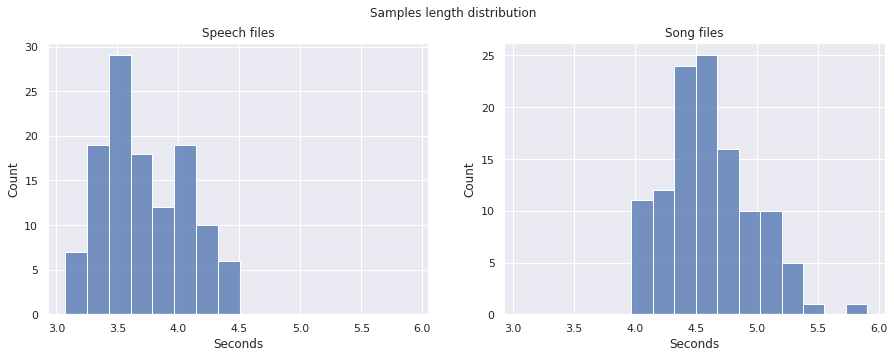

Max len of data samples:  130226


In [2]:
MAX_LEN = show_duration_distribution(speech_path, song_path, limit_per_actor=5)
print("Max len of data samples: ", MAX_LEN)

## Preprocessing and feature extraction

The first step of the methodology consists in extracting the first 13 mfcc from the speech and song files.

In [3]:
MAX_LEN = 140526
fe = FeatureExtractor(speech_path=speech_path, 
                      song_path=song_path,
                      save_path=save_path, 
                      verbose=True, 
                      file_per_actor_limit=-1, 
                      audio_fixed_size=MAX_LEN)

data = fe.get_training_data(overwrite=False)

Data found on disk


# SVM, K-NN and NN comparison

After extracting features, the first part of the project consists in comparing the performance of Neural Networks, SVM and K-NN. They are tested on the emotion label.

In [4]:
d = Dataset(data)
X_train, X_val, X_test, y_train, y_val, y_test = d.get_training_data("merge", train_perc=0.6, val_perc=0.2)

### SVM training

In [5]:
from sklearn.svm import SVC

x, _ = y_train.shape
x2, _ = y_test.shape
reshaped_y_train = y_train.reshape(x)
reshaped_y_test = y_test.reshape(x2)

svm_model = SVC()
svm_model.fit(X_train, reshaped_y_train)
print(f"SVM Accuracy on train: {svm_model.score(X_train, reshaped_y_train)}")
print(f"SVM Accuracy on test:  {svm_model.score(X_test, reshaped_y_test)}")

SVM Accuracy on train: 0.8072122052704577
SVM Accuracy on test:  0.6798336798336798


### KNN training
Here K is set to be sqrt of the number of training samples.

In [6]:
from sklearn.neighbors import KNeighborsClassifier as KNN

k = int(len(y_train)**(1/2))
k += int((k%2)==0)

knn_model = KNN(k)
knn_model.fit(X_train, reshaped_y_train)    

print(f"{k}-NN Accuracy on test: {knn_model.score(X_test, reshaped_y_test)}")

37-NN Accuracy on test: 0.5322245322245323


### Neural network training


In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input 
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from matplotlib import pyplot as plt

nn_model = Sequential()
nn_model.add(Input(shape=X_train[0].shape))
nn_model.add(Dense(200, activation="relu"))
nn_model.add(Dense(80, activation="relu"))
nn_model.add(Dense(30, activation="relu"))
nn_model.add(Dense(8, activation="softmax"))
nn_model.compile(optimizer='sgd', loss=SparseCategoricalCrossentropy(), metrics=["accuracy"])

In [8]:
history = nn_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=70, verbose=1)

Epoch 1/70
46/46 [==============================] - 1s 6ms/step - loss: 1.9835 - accuracy: 0.2365 - val_loss: 1.9308 - val_accuracy: 0.2614
Epoch 2/70
46/46 [==============================] - 0s 3ms/step - loss: 1.7638 - accuracy: 0.3523 - val_loss: 1.8111 - val_accuracy: 0.3195
Epoch 3/70
46/46 [==============================] - 0s 3ms/step - loss: 1.6266 - accuracy: 0.4078 - val_loss: 1.7067 - val_accuracy: 0.3734
Epoch 4/70
46/46 [==============================] - 0s 3ms/step - loss: 1.5043 - accuracy: 0.4771 - val_loss: 1.5924 - val_accuracy: 0.4419
Epoch 5/70
46/46 [==============================] - 0s 3ms/step - loss: 1.3948 - accuracy: 0.5368 - val_loss: 1.5073 - val_accuracy: 0.4523
Epoch 6/70
46/46 [==============================] - 0s 3ms/step - loss: 1.2938 - accuracy: 0.5721 - val_loss: 1.4448 - val_accuracy: 0.4751
Epoch 7/70
46/46 [==============================] - 0s 3ms/step - loss: 1.2056 - accuracy: 0.6061 - val_loss: 1.3649 - val_accuracy: 0.5290
Epoch 8/70
46/46 [==

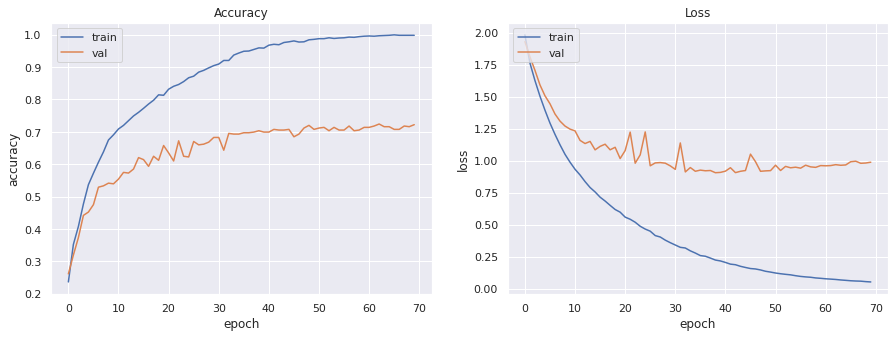

In [9]:
plot_history(history)

In [10]:
nn_model.evaluate(X_test, y_test)

16/16 [==============================] - 0s 2ms/step - loss: 1.0039 - accuracy: 0.6923


[1.00387704372406, 0.692307710647583]